In [1]:
import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"


from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)




plt.rcParams['axes.unicode_minus'] = False

In [2]:
from selenium import webdriver
import time

In [3]:
driver = webdriver.Chrome('../driver/chromedriver')
driver.get("http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09")

In [4]:
driver.find_element_by_id("electionType1").click()

In [5]:
driver.find_element_by_id("electionName").send_keys("제17대")

In [6]:
driver.find_element_by_id("electionCode").send_keys("대통령선거")

In [7]:
sido_list_raw = driver.find_element_by_xpath("""//*[@id="cityCode"]""")
sido_list = sido_list_raw.find_elements_by_tag_name("option")
sido_names_values = [option.text for option in sido_list]
sido_names_values = sido_names_values[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [8]:
import re

def get_num(tmp):
    return float(re.split('\(', str(tmp))[0].replace(',',''))

In [9]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

wait = WebDriverWait(driver, 10)

def move_sido(name):
    element = driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath = """//*[@id="searchBtn"]"""
    wait.until(EC.element_to_be_clickable((By.XPATH,make_xpath)))
    driver.find_element_by_xpath(make_xpath).click()

In [10]:
def append_data(df, sido_name, data):
    for each in df[0].values[1:]:
        data['광역시도'].append(sido_name)
        data['시군'].append(each[0])
        data['pop'].append(get_num(each[2]))
        data['jeong'].append(get_num(each[3]))
        data['lee'].append(get_num(each[4]))
        data['kwon'].append(get_num(each[5]))

In [11]:
election_result_raw = {'광역시도' : [],
                       '시군' : [],
                       'pop' : [],
                       'jeong' : [],
                       'lee' : [],    
                       'kwon' : [] }

In [12]:
from bs4 import BeautifulSoup

for each_sido in sido_names_values:
    move_sido(each_sido)
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')
    
    df = pd.read_html(str(table))
    
    append_data(df, each_sido, election_result_raw)

In [13]:
election_result = pd.DataFrame(election_result_raw, 
                               columns=['광역시도', '시군', 'pop', 'jeong','lee','kwon'])
election_result

,광역시도,시군,pop,jeong,lee,kwon
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0
...,...,...,...,...,...,...
243,경상남도,산청군,21140.0,2055.0,12239.0,1482.0
244,경상남도,거창군,34594.0,3637.0,19863.0,1708.0
245,경상남도,합천군,31741.0,2815.0,18867.0,1626.0
246,제주특별자치도,제주시,181304.0,56798.0,70297.0,7059.0


In [14]:
election_result.to_csv('../data/05. election_result.csv', encoding='utf-8', sep=',')

In [15]:
driver.close()

In [65]:
election_result = pd.read_csv('../data/05. election_result.csv', encoding='utf-8', 
                              index_col=0)
election_result.head()

,광역시도,시군,pop,jeong,lee,kwon
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0


In [66]:
sido_candi =  election_result['광역시도']
sido_candi = [name[:2]
              if name[:2] in ['서울','부산','대구','광주','인천','대전','울산']
              else '' 
              for name in sido_candi]

In [67]:
def cut_char_sigu(name):
    return name if len(name)==2 else name[:-1]

In [68]:
import re

sigun_candi = ['']*len(election_result)

for n in election_result.index:
    each = election_result['시군'][n]
    if each[:2] in ['수원', '성남','안양','안산','고양',
                    '용인','청주','천안','전주','포항','창원']:
        sigun_candi[n] = re.split('시', each)[0]+' '+ \
        cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_candi[n] = cut_char_sigu(each)
        
sigun_candi

['종로',
 '중구',
 '용산',
 '성동',
 '광진',
 '동대문',
 '중랑',
 '성북',
 '강북',
 '도봉',
 '노원',
 '은평',
 '서대문',
 '마포',
 '양천',
 '강서',
 '구로',
 '금천',
 '영등포',
 '동작',
 '관악',
 '서초',
 '강남',
 '송파',
 '강동',
 '중구',
 '서구',
 '동구',
 '영도',
 '부산진',
 '동래',
 '남구',
 '북구',
 '해운대',
 '기장',
 '사하',
 '금정',
 '강서',
 '연제',
 '수영',
 '사상',
 '중구',
 '동구',
 '서구',
 '남구',
 '북구',
 '수성',
 '달서',
 '달성',
 '중구',
 '동구',
 '남구',
 '연수',
 '남동',
 '부평',
 '계양',
 '서구',
 '강화',
 '옹진',
 '동구',
 '서구',
 '남구',
 '북구',
 '광산',
 '동구',
 '중구',
 '서구',
 '유성',
 '대덕',
 '중구',
 '남구',
 '동구',
 '북구',
 '울주',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천시원미',
 '부천시소사',
 '부천시오정',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남',
 '파주',
 '여주',
 '이천',
 '용인 처인',
 '용인 수지',
 '용인 기흥',
 '안성',
 '김포',
 '광주',
 '포천',
 '연천',
 '양평',
 '가평',
 '춘천',
 '원주',
 '강릉',
 '동해',
 '삼척',
 '태백',
 '정선',
 '속초',
 '고성',
 '양양',
 '인제',
 '홍천',
 '횡성',
 '영월',
 '평창',

In [69]:
ID_candi = [sido_candi[n]+' '+sigun_candi[n] for n in range(0,len(sigun_candi))]

ID_candi = [name[1:] if name[0]==' ' else name for name in ID_candi]
ID_candi = [name[:2] if name[:2]=='세종' else name for name in ID_candi]

ID_candi

['서울 종로',
 '서울 중구',
 '서울 용산',
 '서울 성동',
 '서울 광진',
 '서울 동대문',
 '서울 중랑',
 '서울 성북',
 '서울 강북',
 '서울 도봉',
 '서울 노원',
 '서울 은평',
 '서울 서대문',
 '서울 마포',
 '서울 양천',
 '서울 강서',
 '서울 구로',
 '서울 금천',
 '서울 영등포',
 '서울 동작',
 '서울 관악',
 '서울 서초',
 '서울 강남',
 '서울 송파',
 '서울 강동',
 '부산 중구',
 '부산 서구',
 '부산 동구',
 '부산 영도',
 '부산 부산진',
 '부산 동래',
 '부산 남구',
 '부산 북구',
 '부산 해운대',
 '부산 기장',
 '부산 사하',
 '부산 금정',
 '부산 강서',
 '부산 연제',
 '부산 수영',
 '부산 사상',
 '대구 중구',
 '대구 동구',
 '대구 서구',
 '대구 남구',
 '대구 북구',
 '대구 수성',
 '대구 달서',
 '대구 달성',
 '인천 중구',
 '인천 동구',
 '인천 남구',
 '인천 연수',
 '인천 남동',
 '인천 부평',
 '인천 계양',
 '인천 서구',
 '인천 강화',
 '인천 옹진',
 '광주 동구',
 '광주 서구',
 '광주 남구',
 '광주 북구',
 '광주 광산',
 '대전 동구',
 '대전 중구',
 '대전 서구',
 '대전 유성',
 '대전 대덕',
 '울산 중구',
 '울산 남구',
 '울산 동구',
 '울산 북구',
 '울산 울주',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천시원미',
 '부천시소사',
 '부천시오정',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시

In [70]:
election_result['ID'] = ID_candi
election_result.head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0,서울 종로
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0,서울 중구
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0,서울 용산
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0,서울 성동
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0,서울 광진
5,서울특별시,동대문구,190407.0,49064.0,100709.0,4443.0,서울 동대문
6,서울특별시,중랑구,204119.0,54085.0,105608.0,4913.0,서울 중랑
7,서울특별시,성북구,235180.0,60790.0,123186.0,5597.0,서울 성북
8,서울특별시,강북구,168236.0,47290.0,85791.0,4278.0,서울 강북
9,서울특별시,도봉구,188015.0,46515.0,99596.0,4563.0,서울 도봉


In [71]:
election_result[['rate_jeong','rate_lee','rate_kwon']] = \
            election_result[['jeong','lee','kwon']].div(election_result['pop'],  axis=0)
election_result[['rate_jeong','rate_lee','rate_kwon']] *= 100
election_result.head()

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0,서울 종로,25.169630,52.845110,2.209874
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0,서울 중구,26.015099,53.138535,2.085840
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0,서울 용산,22.184347,56.467694,2.014506
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0,서울 성동,25.335115,53.571234,2.304237
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0,서울 광진,25.405644,51.721807,2.267572


In [72]:
election_result.sort_values(['rate_lee'], ascending=[False]).head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
202,경상북도,포항시북구,140685.0,6757.0,118169.0,2678.0,포항 북구,4.802929,83.995451,1.903543
223,경상북도,영덕군,27649.0,1377.0,23129.0,482.0,영덕,4.980289,83.652212,1.743282
203,경상북도,포항시남구,136640.0,8910.0,108775.0,3355.0,포항 남구,6.520785,79.606996,2.455357
204,경상북도,울릉군,5834.0,554.0,4342.0,99.0,울릉,9.496058,74.425780,1.696949
205,경상북도,경주시,145887.0,8968.0,107948.0,6366.0,경주,6.147224,73.994256,4.363651
219,경상북도,군위군,16452.0,1047.0,12147.0,394.0,군위,6.363968,73.832969,2.394846
210,경상북도,영천시,60974.0,4348.0,44263.0,1499.0,영천,7.130908,72.593236,2.458425
225,경상북도,울진군,30078.0,2691.0,21804.0,607.0,울진,8.946738,72.491522,2.018086
220,경상북도,의성군,38182.0,2517.0,27525.0,1493.0,의성,6.592111,72.088942,3.910219
212,경상북도,문경시,43068.0,2834.0,30867.0,856.0,문경,6.580292,71.670382,1.987555


In [73]:
election_result.sort_values(['rate_jeong'], ascending=[False]).head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
177,전라북도,순창군,19324.0,17343.0,771.0,248.0,순창,89.748499,3.989857,1.283378
170,전라북도,남원시,49456.0,42232.0,3299.0,613.0,남원,85.393077,6.670576,1.239486
176,전라북도,임실군,19427.0,16454.0,1276.0,200.0,임실,84.696556,6.568178,1.029495
178,전라북도,고창군,34236.0,28901.0,2308.0,533.0,고창,84.416988,6.741442,1.556841
169,전라북도,정읍시,65233.0,54890.0,4835.0,1231.0,정읍,84.144528,7.411893,1.887082
171,전라북도,김제시,54726.0,46019.0,4250.0,772.0,김제,84.089829,7.765961,1.410664
185,전라남도,담양군,28834.0,23872.0,1974.0,436.0,담양,82.791149,6.846084,1.512104
173,전라북도,진안군,16059.0,13276.0,1240.0,234.0,진안,82.670154,7.721527,1.457127
172,전라북도,완주군,44710.0,36557.0,3500.0,1292.0,완주,81.764706,7.828226,2.889734
175,전라북도,장수군,14224.0,11614.0,1151.0,309.0,장수,81.650731,8.091957,2.172385


In [74]:
election_result.sort_values(['rate_kwon'], ascending=[False]).head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
72,울산광역시,북구,71100.0,10201.0,33363.0,11797.0,울산 북구,14.347398,46.924051,16.592124
71,울산광역시,동구,87909.0,16129.0,43337.0,9098.0,울산 동구,18.347382,49.297569,10.349339
235,경상남도,거제시,88567.0,13614.0,45598.0,8622.0,거제,15.371414,51.484187,9.735003
226,경상남도,창원시,231700.0,29081.0,119272.0,18327.0,창원,12.551144,51.476910,7.909797
69,울산광역시,중구,112934.0,13670.0,63101.0,8371.0,울산 중구,12.104415,55.874227,7.412294
243,경상남도,산청군,21140.0,2055.0,12239.0,1482.0,산청,9.720908,57.894986,7.010407
237,경상남도,함안군,36737.0,3930.0,19584.0,2317.0,함안,10.697662,53.308653,6.306993
236,경상남도,의령군,18150.0,1849.0,9440.0,1103.0,의령,10.187328,52.011019,6.077135
70,울산광역시,남구,163310.0,19581.0,92717.0,9549.0,울산 남구,11.990080,56.773621,5.847162
88,경기도,평택시,176789.0,37120.0,88319.0,10314.0,평택,20.996781,49.957294,5.834073


In [75]:
draw_korea = pd.read_csv('../data/05. draw_korea.csv', encoding='utf-8', 
                                                                                                 index_col=0)
draw_korea.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [76]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'고성(강원)',
 '고성(경남)',
 '부천 소사',
 '부천 오정',
 '부천 원미',
 '세종',
 '창원 성산',
 '창원 의창',
 '창원 진해',
 '창원 합포',
 '창원 회원',
 '천안 동남',
 '천안 서북',
 '청주 서원',
 '청주 청원'}

In [77]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'고성', '마산', '부천시소사', '부천시오정', '부천시원미', '연기', '진해', '창원 ', '천안 ', '청원'}

In [78]:
election_result[election_result['ID'] == '고성']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
126,강원도,고성군,16112.0,3053.0,9058.0,508.0,고성,18.948610,56.218967,3.152929
231,경상남도,고성군,29676.0,3268.0,16716.0,1254.0,고성,11.012266,56.328346,4.225637


In [79]:
election_result.loc[126, 'ID'] = '고성(강원)'
election_result.loc[231, 'ID'] = '고성(경남)'

election_result[election_result['시군'] == '고성군']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
126,강원도,고성군,16112.0,3053.0,9058.0,508.0,고성(강원),18.948610,56.218967,3.152929
231,경상남도,고성군,29676.0,3268.0,16716.0,1254.0,고성(경남),11.012266,56.328346,4.225637


In [80]:
election_result[election_result['ID'] == '천안 ']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
149,충청남도,천안시,223871.0,47217.0,90229.0,8381.0,천안,21.091164,40.304014,3.743674


In [81]:
election_result.tail()

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
243,경상남도,산청군,21140.0,2055.0,12239.0,1482.0,산청,9.720908,57.894986,7.010407
244,경상남도,거창군,34594.0,3637.0,19863.0,1708.0,거창,10.513384,57.417471,4.937272
245,경상남도,합천군,31741.0,2815.0,18867.0,1626.0,합천,8.868656,59.440471,5.122712
246,제주특별자치도,제주시,181304.0,56798.0,70297.0,7059.0,제주,31.327494,38.773000,3.893461
247,제주특별자치도,서귀포시,70807.0,24772.0,26198.0,3895.0,서귀포,34.985242,36.999167,5.500869


In [82]:
jeong_tmp = election_result.loc[149, 'jeong']/2
lee_tmp = election_result.loc[149, 'lee']/2
kwon_tmp = election_result.loc[149, 'kwon']/2
pop_tmp = election_result.loc[149, 'pop']/2

rate_jeong_tmp = election_result.loc[149, 'rate_jeong']
rate_lee_tmp = election_result.loc[149, 'rate_lee']
rate_kwon_tmp = election_result.loc[149, 'rate_kwon']

election_result.loc[248] = ['충청남도', '천안시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '천안 서북',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]
                            
election_result.loc[249] = ['충청남도', '천안시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '천안 동남',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]

In [83]:
election_result[election_result['시군'] == '천안시']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
149,충청남도,천안시,223871.0,47217.0,90229.0,8381.0,천안,21.091164,40.304014,3.743674
248,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 서북,21.091164,40.304014,3.743674
249,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 동남,21.091164,40.304014,3.743674


In [84]:
election_result.drop([149], inplace=True)
election_result[election_result['시군'] == '천안시']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
248,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 서북,21.091164,40.304014,3.743674
249,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 동남,21.091164,40.304014,3.743674


In [85]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'부천 소사',
 '부천 오정',
 '부천 원미',
 '세종',
 '창원 성산',
 '창원 의창',
 '창원 진해',
 '창원 합포',
 '창원 회원',
 '청주 서원',
 '청주 청원'}

In [86]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'마산', '부천시소사', '부천시오정', '부천시원미', '연기', '진해', '창원 ', '청원'}

In [87]:
election_result[election_result['ID'] == '부천시소사']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
85,경기도,부천시소사구,106639.0,28322.0,50341.0,3110.0,부천시소사,26.558764,47.206932,2.916381


In [88]:
election_result.loc[85, 'ID'] = '부천 소사'
election_result[election_result['ID'] == '부천시오정']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
86,경기도,부천시오정구,79906.0,24222.0,36051.0,2150.0,부천시오정,30.313118,45.116762,2.690662


In [89]:
election_result.loc[86, 'ID'] = '부천 오정'
election_result[election_result['ID'] == '부천시원미']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
84,경기도,부천시원미구,202315.0,53939.0,95829.0,5636.0,부천시원미,26.6609,47.366236,2.785755


In [90]:
election_result.loc[84, 'ID'] = '부천 원미'
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'마산', '연기', '진해', '창원 ', '청원'}

In [91]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'세종', '창원 성산', '창원 의창', '창원 진해', '창원 합포', '창원 회원', '청주 서원', '청주 청원'}

In [92]:
election_result[election_result['ID'] == '창원 ']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
226,경상남도,창원시,231700.0,29081.0,119272.0,18327.0,창원,12.551144,51.47691,7.909797


In [93]:
election_result.tail()

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
245,경상남도,합천군,31741.0,2815.0,18867.0,1626.0,합천,8.868656,59.440471,5.122712
246,제주특별자치도,제주시,181304.0,56798.0,70297.0,7059.0,제주,31.327494,38.773000,3.893461
247,제주특별자치도,서귀포시,70807.0,24772.0,26198.0,3895.0,서귀포,34.985242,36.999167,5.500869
248,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 서북,21.091164,40.304014,3.743674
249,충청남도,천안시,111935.5,23608.5,45114.5,4190.5,천안 동남,21.091164,40.304014,3.743674


In [94]:
jeong_tmp = election_result.loc[226, 'jeong']/2
lee_tmp = election_result.loc[226, 'lee']/2
kwon_tmp = election_result.loc[226, 'kwon']/2
pop_tmp = election_result.loc[226, 'pop']/2

rate_jeong_tmp = election_result.loc[226, 'rate_jeong']
rate_lee_tmp = election_result.loc[226, 'rate_lee']
rate_kwon_tmp = election_result.loc[226, 'rate_kwon']

election_result.loc[250] = ['경상남도', '창원시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '창원 성산',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]
                            
election_result.loc[251] = ['경상남도', '창원시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '창원 의창',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]



jeong_tmp = election_result.loc[227, 'jeong']/2
lee_tmp = election_result.loc[227, 'lee']/2
kwon_tmp = election_result.loc[227, 'kwon']/2
pop_tmp = election_result.loc[227, 'pop']/2

rate_jeong_tmp = election_result.loc[227, 'rate_jeong']
rate_lee_tmp = election_result.loc[227, 'rate_lee']
rate_kwon_tmp = election_result.loc[227, 'rate_kwon']

election_result.loc[252] = ['경상남도', '창원시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '창원 합포',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]

election_result.loc[253] = ['경상남도', '창원시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '창원 회원',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]

In [95]:
election_result[election_result['시군'] == '창원시']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
226,경상남도,창원시,231700.0,29081.0,119272.0,18327.0,창원,12.551144,51.476910,7.909797
250,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 성산,12.551144,51.476910,7.909797
251,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 의창,12.551144,51.476910,7.909797
252,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 합포,9.834944,58.381973,4.176634
253,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 회원,9.834944,58.381973,4.176634


In [96]:
election_result.drop([226], inplace=True)
election_result.drop([227], inplace=True)

election_result[election_result['시군'] == '창원시']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
250,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 성산,12.551144,51.476910,7.909797
251,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 의창,12.551144,51.476910,7.909797
252,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 합포,9.834944,58.381973,4.176634
253,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 회원,9.834944,58.381973,4.176634


In [97]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'연기', '진해', '청원'}

In [98]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'세종', '창원 진해', '청주 서원', '청주 청원'}

In [99]:
election_result[election_result['ID'] == '청원']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
141,충청북도,청원군,67302.0,18173.0,25120.0,2309.0,청원,27.002169,37.324299,3.430804


In [100]:
jeong_tmp = election_result.loc[141, 'jeong']/2
lee_tmp = election_result.loc[141, 'lee']/2
kwon_tmp = election_result.loc[141, 'kwon']/2
pop_tmp = election_result.loc[141, 'pop']/2

rate_jeong_tmp = election_result.loc[141, 'rate_jeong']
rate_lee_tmp = election_result.loc[141, 'rate_lee']
rate_kwon_tmp = election_result.loc[141, 'rate_kwon']

election_result.loc[254] = ['충청북도', '청주시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '청주 청원',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]
                            
election_result.loc[255] = ['충청북도', '청주시', 
                            pop_tmp, jeong_tmp, lee_tmp, kwon_tmp,
                            '청주 서원',
                            rate_jeong_tmp, rate_lee_tmp, rate_kwon_tmp]

In [101]:
election_result.drop([141], inplace=True)

set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'연기', '진해'}

In [102]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'세종', '창원 진해'}

In [103]:
election_result[election_result['광역시도'] == '충청북도']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
136,충청북도,청주시상당구,111986.0,24361.0,46133.0,3349.0,청주 상당,21.753612,41.195328,2.990552
137,충청북도,청주시흥덕구,165610.0,36408.0,66251.0,5506.0,청주 흥덕,21.984180,40.004227,3.324678
138,충청북도,충주시,94852.0,20282.0,45089.0,2972.0,충주,21.382786,47.536162,3.133302
139,충청북도,제천시,66705.0,13123.0,30743.0,2620.0,제천,19.673188,46.087999,3.927742
140,충청북도,단양군,17457.0,3873.0,7552.0,633.0,단양,22.185943,43.260583,3.626053
142,충청북도,영동군,27267.0,7113.0,11464.0,1170.0,영동,26.086478,42.043496,4.290901
143,충청북도,보은군,19907.0,6978.0,6880.0,726.0,보은,35.052996,34.560707,3.646958
144,충청북도,옥천군,29097.0,9178.0,9731.0,1160.0,옥천,31.542771,33.443310,3.986665
145,충청북도,음성군,39820.0,10210.0,16303.0,1823.0,음성,25.640382,40.941738,4.578101
146,충청북도,진천군,27916.0,7549.0,10792.0,1446.0,진천,27.041840,38.658834,5.179825


In [104]:
election_result[election_result['ID'] == '연기']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
156,충청남도,연기군,42235.0,10525.0,11585.0,1042.0,연기,24.92009,27.429857,2.467148


In [105]:
election_result.loc[156, 'ID'] = '세종'
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'진해'}

In [106]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'창원 진해'}

In [107]:
election_result[election_result['시군'] == '창원시']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
250,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 성산,12.551144,51.476910,7.909797
251,경상남도,창원시,115850.0,14540.5,59636.0,9163.5,창원 의창,12.551144,51.476910,7.909797
252,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 합포,9.834944,58.381973,4.176634
253,경상남도,창원시,104510.0,10278.5,61015.0,4365.0,창원 회원,9.834944,58.381973,4.176634


In [108]:
election_result[election_result['광역시도'] == '경상남도']

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon
228,경상남도,진주시,167564.0,15332.0,97767.0,7752.0,진주,9.149937,58.346065,4.626292
229,경상남도,진해시,79408.0,9834.0,43764.0,3417.0,진해,12.384143,55.112835,4.303093
230,경상남도,통영시,64408.0,6610.0,38853.0,2293.0,통영,10.262700,60.323252,3.560117
231,경상남도,고성군,29676.0,3268.0,16716.0,1254.0,고성(경남),11.012266,56.328346,4.225637
232,경상남도,사천시,57258.0,5945.0,31520.0,2774.0,사천,10.382829,55.049076,4.844738
233,경상남도,김해시,196486.0,33010.0,94923.0,8619.0,김해,16.800179,48.310312,4.386572
234,경상남도,밀양시,59131.0,7002.0,32527.0,2255.0,밀양,11.841504,55.008371,3.813566
235,경상남도,거제시,88567.0,13614.0,45598.0,8622.0,거제,15.371414,51.484187,9.735003
236,경상남도,의령군,18150.0,1849.0,9440.0,1103.0,의령,10.187328,52.011019,6.077135
237,경상남도,함안군,36737.0,3930.0,19584.0,2317.0,함안,10.697662,53.308653,6.306993


In [109]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'진해'}

In [110]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'창원 진해'}

In [111]:
election_result.loc[229, 'ID'] = '창원 진해'

In [112]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

set()

In [113]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

set()

In [114]:
final_elect_data = pd.merge(election_result, draw_korea, how='left', on=['ID'])
final_elect_data.head()

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon,y,x
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0,서울 종로,25.169630,52.845110,2.209874,4,6
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0,서울 중구,26.015099,53.138535,2.085840,5,6
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0,서울 용산,22.184347,56.467694,2.014506,6,6
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0,서울 성동,25.335115,53.571234,2.304237,5,7
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0,서울 광진,25.405644,51.721807,2.267572,6,7


In [122]:
final_elect_data['lee_vs_jeong'] = final_elect_data['rate_jeong'] - \
                                                                final_elect_data['rate_lee']
final_elect_data['jeong_vs_kwon'] = final_elect_data['rate_jeong'] - \
                                                                final_elect_data['rate_kwon']
final_elect_data['kwon_vs_lee'] = final_elect_data['rate_kwon'] - \
                                                                final_elect_data['rate_lee']
final_elect_data.head()

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon,y,x,jeong_vs_lee,jeong_vs_kwon,kwon_vs_lee,lee_vs_jeong
0,서울특별시,종로구,85480.0,21515.0,45172.0,1889.0,서울 종로,25.169630,52.845110,2.209874,4,6,-27.675480,22.959757,-50.635236,-27.675480
1,서울특별시,중구,66496.0,17299.0,35335.0,1387.0,서울 중구,26.015099,53.138535,2.085840,5,6,-27.123436,23.929259,-51.052695,-27.123436
2,서울특별시,용산구,117051.0,25967.0,66096.0,2358.0,서울 용산,22.184347,56.467694,2.014506,6,6,-34.283347,20.169840,-54.453187,-34.283347
3,서울특별시,성동구,165391.0,41902.0,88602.0,3811.0,서울 성동,25.335115,53.571234,2.304237,5,7,-28.236119,23.030878,-51.266998,-28.236119
4,서울특별시,광진구,183412.0,46597.0,94864.0,4159.0,서울 광진,25.405644,51.721807,2.267572,6,7,-26.316163,23.138072,-49.454234,-26.316163


In [123]:
final_elect_data.sort_values(['lee_vs_jeong'], ascending=[False]).head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon,y,x,jeong_vs_lee,jeong_vs_kwon,kwon_vs_lee,lee_vs_jeong
175,전라북도,순창군,19324.0,17343.0,771.0,248.0,순창,89.748499,3.989857,1.283378,20,3,85.758642,88.465121,-2.706479,85.758642
168,전라북도,남원시,49456.0,42232.0,3299.0,613.0,남원,85.393077,6.670576,1.239486,18,5,78.722501,84.153591,-5.431090,78.722501
174,전라북도,임실군,19427.0,16454.0,1276.0,200.0,임실,84.696556,6.568178,1.029495,19,4,78.128378,83.667061,-5.538683,78.128378
176,전라북도,고창군,34236.0,28901.0,2308.0,533.0,고창,84.416988,6.741442,1.556841,18,1,77.675546,82.860147,-5.184601,77.675546
167,전라북도,정읍시,65233.0,54890.0,4835.0,1231.0,정읍,84.144528,7.411893,1.887082,18,2,76.732635,82.257446,-5.524811,76.732635
169,전라북도,김제시,54726.0,46019.0,4250.0,772.0,김제,84.089829,7.765961,1.410664,17,3,76.323868,82.679165,-6.355297,76.323868
183,전라남도,담양군,28834.0,23872.0,1974.0,436.0,담양,82.791149,6.846084,1.512104,20,2,75.945065,81.279046,-5.333981,75.945065
171,전라북도,진안군,16059.0,13276.0,1240.0,234.0,진안,82.670154,7.721527,1.457127,18,4,74.948627,81.213027,-6.264400,74.948627
185,전라남도,곡성군,19181.0,15521.0,1247.0,618.0,곡성,80.918617,6.501225,3.221938,21,3,74.417392,77.696679,-3.279287,74.417392
170,전라북도,완주군,44710.0,36557.0,3500.0,1292.0,완주,81.764706,7.828226,2.889734,17,4,73.936480,78.874972,-4.938493,73.936480


In [124]:
final_elect_data.sort_values(['lee_vs_jeong'], ascending=[True]).head(10)

,광역시도,시군,pop,jeong,lee,kwon,ID,rate_jeong,rate_lee,rate_kwon,y,x,jeong_vs_lee,jeong_vs_kwon,kwon_vs_lee,lee_vs_jeong
200,경상북도,포항시북구,140685.0,6757.0,118169.0,2678.0,포항 북구,4.802929,83.995451,1.903543,10,12,-79.192522,2.899385,-82.091907,-79.192522
221,경상북도,영덕군,27649.0,1377.0,23129.0,482.0,영덕,4.980289,83.652212,1.743282,7,11,-78.671923,3.237007,-81.908930,-78.671923
201,경상북도,포항시남구,136640.0,8910.0,108775.0,3355.0,포항 남구,6.520785,79.606996,2.455357,11,12,-73.086212,4.065427,-77.151639,-73.086212
203,경상북도,경주시,145887.0,8968.0,107948.0,6366.0,경주,6.147224,73.994256,4.363651,12,12,-67.847032,1.783572,-69.630605,-67.847032
217,경상북도,군위군,16452.0,1047.0,12147.0,394.0,군위,6.363968,73.832969,2.394846,11,10,-67.469001,3.969122,-71.438123,-67.469001
46,대구광역시,수성구,230474.0,12665.0,164557.0,3851.0,대구 수성,5.495197,71.399377,1.670904,14,10,-65.904180,3.824293,-69.728473,-65.904180
218,경상북도,의성군,38182.0,2517.0,27525.0,1493.0,의성,6.592111,72.088942,3.910219,11,11,-65.496831,2.681892,-68.178723,-65.496831
208,경상북도,영천시,60974.0,4348.0,44263.0,1499.0,영천,7.130908,72.593236,2.458425,12,10,-65.462328,4.672483,-70.134812,-65.462328
41,대구광역시,중구,43459.0,2502.0,30882.0,706.0,대구 중구,5.757150,71.060080,1.624520,14,9,-65.302929,4.132631,-69.435560,-65.302929
210,경상북도,문경시,43068.0,2834.0,30867.0,856.0,문경,6.580292,71.670382,1.987555,8,10,-65.090090,4.592737,-69.682827,-65.090090


In [125]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
    [(27,5), (27,6), (25,6)],
]

In [126]:
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                                  np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

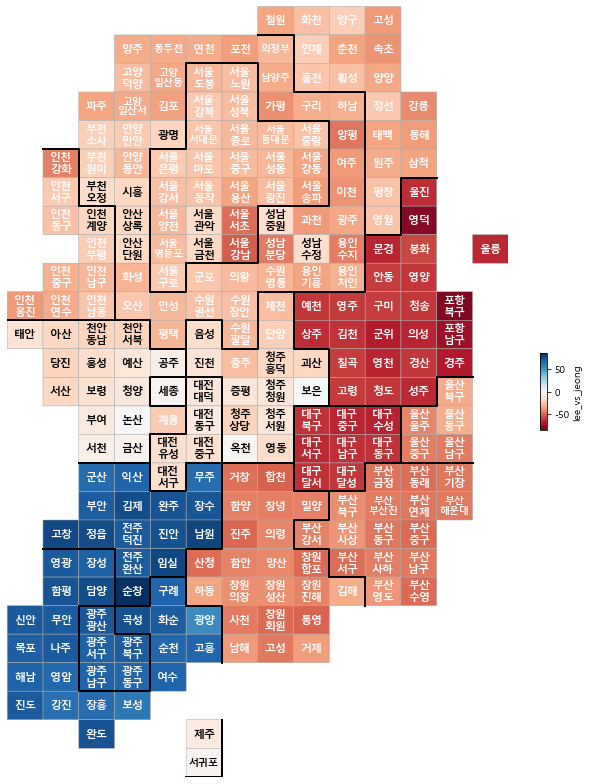

In [127]:
drawKorea('lee_vs_jeong', final_elect_data, 'RdBu')

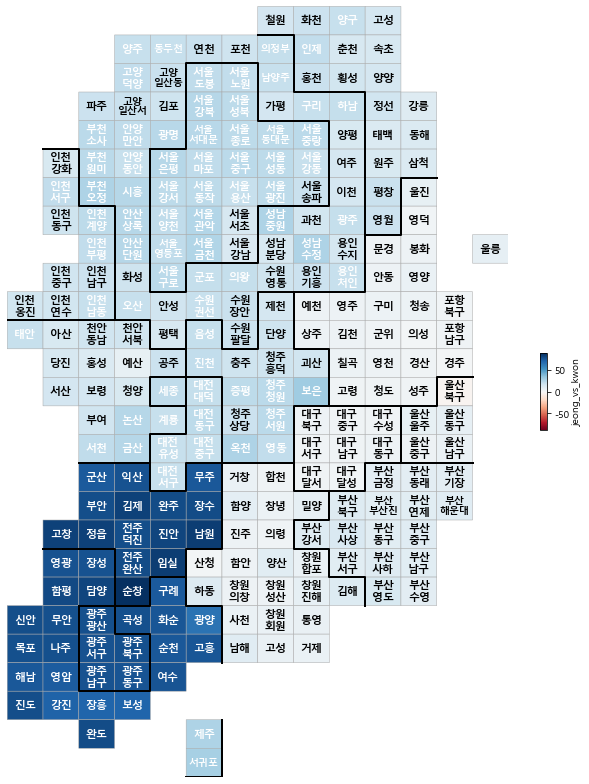

In [128]:
drawKorea('jeong_vs_kwon', final_elect_data, 'RdBu')

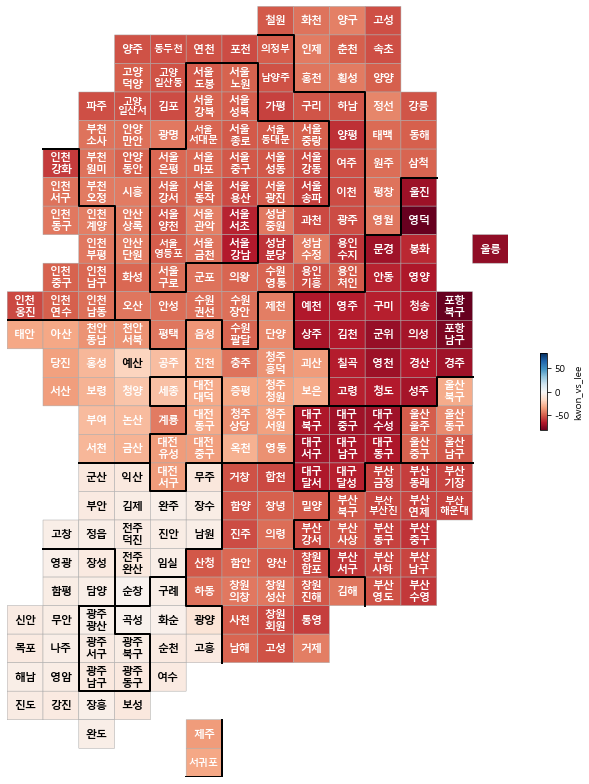

In [129]:
drawKorea('kwon_vs_lee', final_elect_data, 'RdBu')

In [130]:
import folium
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [131]:
pop_folium = final_elect_data.set_index('ID')

del pop_folium['광역시도']
del pop_folium['시군']

pop_folium.head()

,pop,jeong,lee,kwon,rate_jeong,rate_lee,rate_kwon,y,x,jeong_vs_lee,jeong_vs_kwon,kwon_vs_lee,lee_vs_jeong
ID,,,,,,,,,,,,,
서울 종로,85480.0,21515.0,45172.0,1889.0,25.169630,52.845110,2.209874,4,6,-27.675480,22.959757,-50.635236,-27.675480
서울 중구,66496.0,17299.0,35335.0,1387.0,26.015099,53.138535,2.085840,5,6,-27.123436,23.929259,-51.052695,-27.123436
서울 용산,117051.0,25967.0,66096.0,2358.0,22.184347,56.467694,2.014506,6,6,-34.283347,20.169840,-54.453187,-34.283347
서울 성동,165391.0,41902.0,88602.0,3811.0,25.335115,53.571234,2.304237,5,7,-28.236119,23.030878,-51.266998,-28.236119
서울 광진,183412.0,46597.0,94864.0,4159.0,25.405644,51.721807,2.267572,6,7,-26.316163,23.138072,-49.454234,-26.316163


In [ ]:
geo_path = '../data/05. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[36.2002, 127.054], zoom_start=6)
map.choropleth(geo_data = geo_str,
               data = pop_folium['moon_vs_hong'],
               columns = [pop_folium.index, pop_folium['moon_vs_hong']],
               fill_color = 'PuBu', #PuRd, YlGnBu
               key_on = 'feature.id')

map